# Drug Side Effect Prediction - Armaan Sait - CS5100

# SetUp

In [ ]:
!pip install catboost scikit_learn lightgbm xgboost

In [1]:
# Importing Modules for Data Manupulation & Visualization
import pandas as pd   
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from math import pi

# Importing Modules for Machine Learning
import pickle
import json
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load Data

In [2]:
# Download and Load the SIDER Dataset
def load_data():
    side_effects_url = "http://sideeffects.embl.de/media/download/meddra_all_se.tsv.gz"
    drug_names_url = "http://sideeffects.embl.de/media/download/drug_names.tsv"
    disease_data_url = "https://www.kaggle.com/api/v1/datasets/download/manncodes/drug-prescription-to-disease-dataset?dataset_version_number=1"

    
    side_effects_df = pd.read_csv(
        side_effects_url,
        sep='\t',
        compression='gzip',
        names=[
            'compound_id_flat', 
            'compound_id_stereo', 
            'label_umls_id', 
            'meddra_type', 
            'meddra_umls_id', 
            'side_effect_name'
        ]
    )
    drug_names_df = pd.read_csv(drug_names_url, sep='\t', names=['compound_id_flat', 'drug_name'])
    disease_data_df = pd.read_csv(disease_data_url, sep=',', compression='zip')[['disease', 'drug']]
    

    return side_effects_df, drug_names_df, disease_data_df


In [3]:
side_effects_df, drug_names_df, disease_data_df = load_data()

In [4]:
# Save each dataframe to a separate CSV file for the Website Creation later
# side_effects_df.to_csv('../data/side_effects.csv', index=False)
# drug_names_df.to_csv('../data/drug_names.csv', index=False)
# disease_data_df.to_csv('../data/disease_data.csv', index=False)

# Data EDA

In [5]:
# Shape of the DataFrames

print(f"Side Effects DF: {side_effects_df.shape[0]} records & {side_effects_df.shape[1]} columns")
print(f"Drug Names   DF: {drug_names_df.shape[0]} records & {drug_names_df.shape[1]} columns")
print(f"Disease Drug DF: {disease_data_df.shape[0]} records & {disease_data_df.shape[1]} columns")

Side Effects DF: 309849 records & 6 columns
Drug Names   DF: 1430 records & 2 columns
Disease Drug DF: 14683 records & 2 columns


### Check for missing values

In [6]:
# Checking for Missing Values and fill them if any

missing_in_side_effect = {col: count for col, count in side_effects_df.isnull().sum().items() if count > 0}
print(f"\nMissing values in Side Effects DataFrame: {missing_in_side_effect if missing_in_side_effect else 'None'}")

for col in missing_in_side_effect.keys():
    mode_value = side_effects_df[col].mode()[0]  # Get the mode of the column
    side_effects_df[col] = side_effects_df[col].fillna(mode_value)  # Fill the missing values with the mode

missing_in_drug_names = {col: count for col, count in drug_names_df.isnull().sum().items() if count > 0}
print(f"\nMissing values in Drug Names DataFrame: {missing_in_drug_names if missing_in_drug_names else 'None'}")

missing_in_disease_df = {col: count for col, count in disease_data_df.isnull().sum().items() if count > 0}
print(f"\nMissing values in Disease Data DataFrame: {missing_in_disease_df if missing_in_disease_df else 'None'}")


Missing values in Side Effects DataFrame: {'meddra_type': 901, 'meddra_umls_id': 901}

Missing values in Drug Names DataFrame: None

Missing values in Disease Data DataFrame: None


### Dropping Duplicates 

In [7]:
disease_data_df = disease_data_df.drop_duplicates() # Dropping duplicates because duplicates present in source

### Combining multiple dataframes

In [8]:
# Perform inner join between all three dataframes

merged_df = side_effects_df.merge(drug_names_df, on='compound_id_flat').merge(disease_data_df, left_on='drug_name', right_on='drug') # 1562790 rows
drug_se_df = side_effects_df.merge(drug_names_df, on='compound_id_flat') # 309849 rows

### Data Analytics

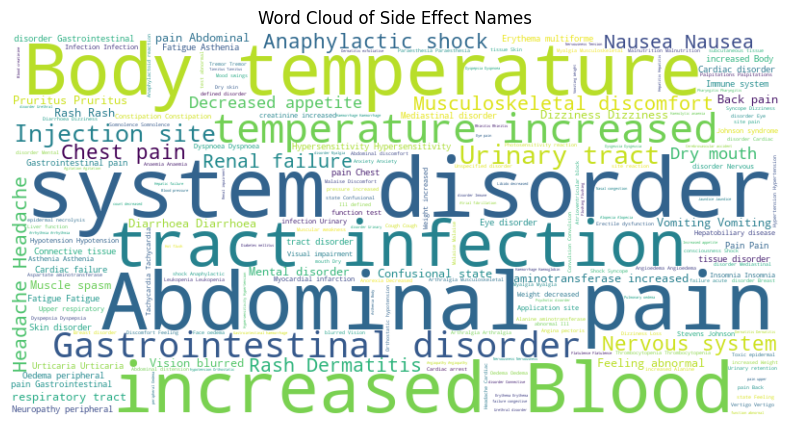

In [9]:
# Generate a word cloud for side effect names

side_effects_text = ' '.join(side_effects_df['side_effect_name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(side_effects_text)

# Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Side Effect Names')
plt.show()

## These show the side effects which occur the most

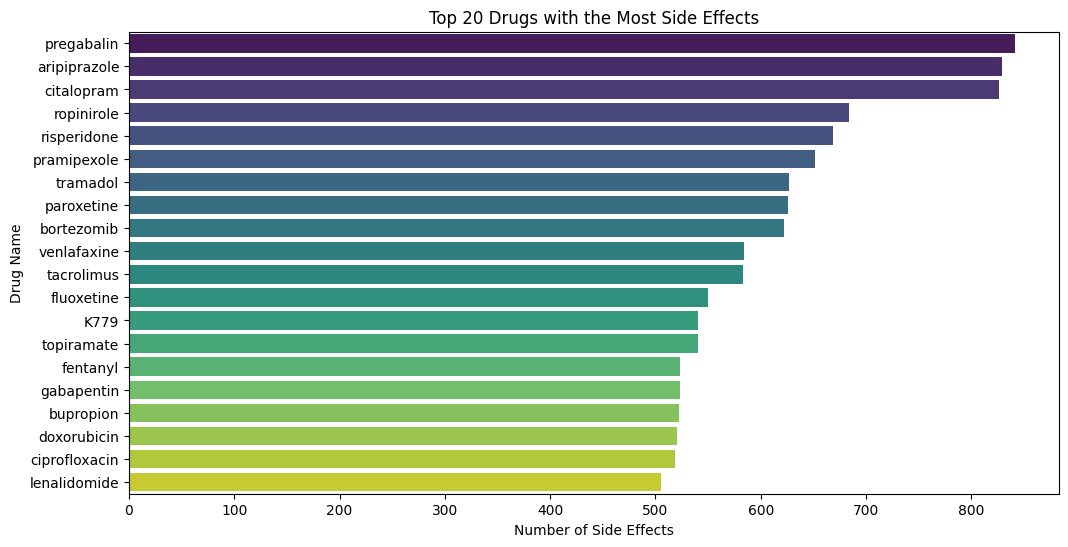

In [10]:
# Counting the number of side effects for each drug

side_effects_count = (
    drug_se_df.groupby('drug_name')['side_effect_name']
    .nunique()  # Count distinct side effects
    .reset_index()
    .sort_values(by='side_effect_name', ascending=False)
)
side_effects_count.columns = ['drug_name', 'side_effect_count']

# Plotting the top 20 drugs with the most side effects
plt.figure(figsize=(12, 6))
sns.barplot(
    x='side_effect_count', 
    y='drug_name', 
    data=side_effects_count.head(20), 
    hue='drug_name',  # Assigning hue to the y variable
    dodge=False,  # To avoid bars overlapping due to hue
    palette='viridis', 
    legend=False  # Hiding the legend since we only need a color mapping
)
plt.title('Top 20 Drugs with the Most Side Effects')
plt.xlabel('Number of Side Effects')
plt.ylabel('Drug Name')
plt.show()

## The above plot shows the top 20 drugs with the most side effects.

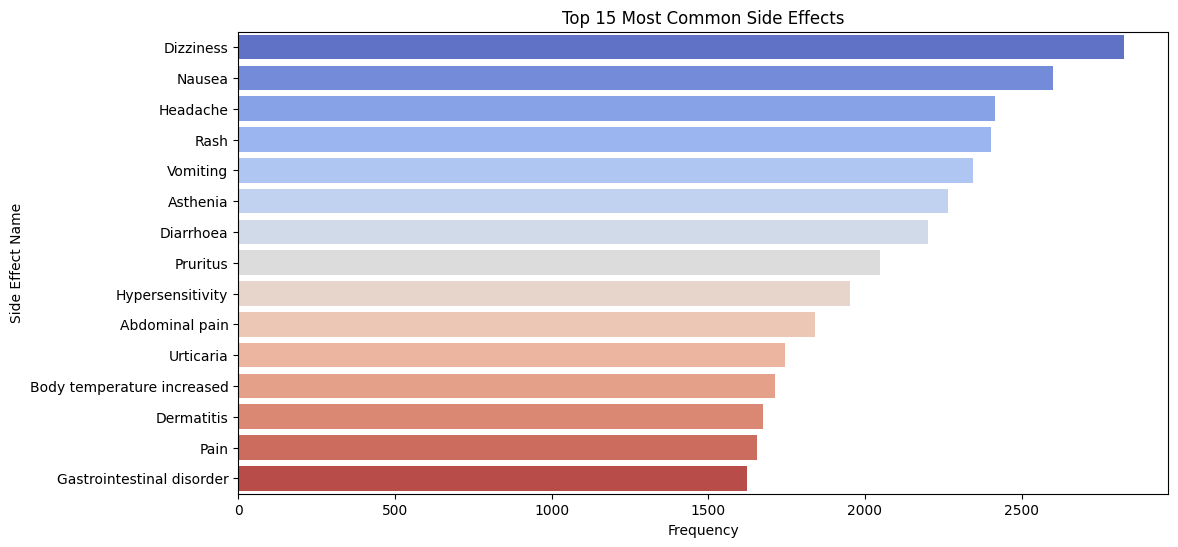

In [11]:
# Counting the number of drugs for each side effect

common_side_effects = side_effects_df['side_effect_name'].value_counts().reset_index()
common_side_effects.columns = ['side_effect_name', 'count']

# Plotting the top 15 most common side effects
plt.figure(figsize=(12, 6))
sns.barplot(
    x='count', 
    y='side_effect_name', 
    data=common_side_effects.head(15), 
    hue='side_effect_name',
    dodge=False,
    palette='coolwarm', 
    legend=False
)
plt.title('Top 15 Most Common Side Effects')
plt.xlabel('Frequency')
plt.ylabel('Side Effect Name')
plt.show()

## The graph below shows the most common side effects that occur in patients.

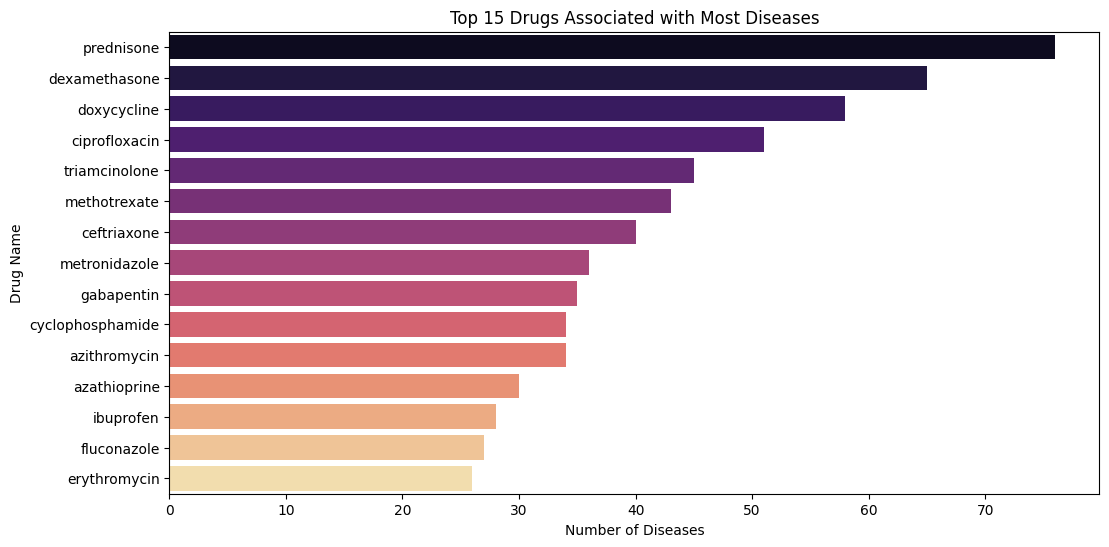

In [12]:
# Top 15 Drugs associated with the most diseases
# Count the number of diseases associated with each drug

disease_count = disease_data_df['drug'].value_counts().reset_index()
disease_count.columns = ['drug_name', 'disease_count']

# Plotting the top 15 drugs associated with the most diseases
plt.figure(figsize=(12, 6))
sns.barplot(
    x='disease_count', 
    y='drug_name', 
    data=disease_count.head(15), 
    hue='drug_name',
    dodge=False,
    palette='magma', 
    legend=False
)
plt.title('Top 15 Drugs Associated with Most Diseases')
plt.xlabel('Number of Diseases')
plt.ylabel('Drug Name')
plt.show()

## The graph below shows the top 15 drugs that are associated with the most diseases.

In [13]:
# Same Drug name has multipe drug ids
# Group, filter, aggregate, and sort
result = (
    drug_names_df.groupby('drug_name')
    .filter(lambda x: x['compound_id_flat'].nunique() > 1)  # Filter drug names with multiple unique IDs
    .groupby('drug_name')
    .agg({'compound_id_flat': lambda ids: list(pd.unique(ids))})  # Aggregate unique IDs into a list
    .reset_index()
    .assign(id_count=lambda x: x['compound_id_flat'].apply(len))  # Add a count of unique IDs
    .sort_values(by='id_count', ascending=False)  # Sort by the count of IDs in descending order
)

print(result) ## This is valid because of following reasons
# 1. The same drug can be in multiple dormulations, dosages or strengths.
# 2. The same drug can be marketed by multiple companies under different names.
# 3. The same drug can have different ids in different regions.

        drug_name                                   compound_id_flat  id_count
57         sodium  [CID100000923, CID100002881, CID100003737, CID...        11
60   testosterone  [CID100005408, CID100005409, CID100005410, CID...         4
0             CAS         [CID100003222, CID100065281, CID100443379]         3
23      estradiol         [CID100000450, CID100003263, CID100003267]         3
51   prednisolone         [CID100004894, CID100004895, CID100004896]         3
..            ...                                                ...       ...
28   fluphenazine                       [CID100003372, CID100003388]         2
30  fosaprepitant                       [CID100219090, CID106918366]         2
31     fosfomycin                       [CID100003417, CID100054331]         2
1       Photofrin                       [CID100057166, CID103086257]         2
63           zinc                       [CID100023994, CID100024424]         2

[64 rows x 3 columns]


# Model Creation

### Common Function to reuse and store results

In [14]:
## Here we are going to preprocess the data for the machine learning model
## We are going to use the side effects and drug names dataframes to create a pivot table
## The pivot table will have the drug names as the index and the side effects as the columns
## The values will be 1 if the side effect is present for the drug and 0 if it is not present


def preprocess_data(side_effects_df, drug_names_df):
    data = side_effects_df.merge(drug_names_df, on='compound_id_flat')
    data['presence'] = 1
    pivot_df = data.pivot_table(index='drug_name', columns='side_effect_name', 
                                values='presence', fill_value=0)
    pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]
    return pivot_df

In [15]:
# Store Results Across modules

results = []

def append_results(model_name, accuracy, precision, recall, f1_score):
    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

In [16]:
## Model to be saved and used in the front end


def save_results(model, label_encoder, accuracy, report, save_path="model"):
    # Save model and label encoder
    model_dict = {
        'model': model,
        'label_encoder': label_encoder
    }
    
    with open(f"../{save_path}/drug_side_effects_lightGBM_model.pkl", "wb") as f:
        pickle.dump(model_dict, f)
    
    # Save metrics and results
    results = {
        'accuracy': float(accuracy),
        'precision': float(report['weighted avg']['precision']),
        'recall': float(report['weighted avg']['recall']),
        'f1_score': float(report['weighted avg']['f1-score']),
        'support': int(report['weighted avg']['support']),
        'detailed_report': report
    }
    
    with open(f"../{save_path}/model_results.json", "w") as f:
        json.dump(results, f, indent=4)
    
    print(f"Model, label encoder, and results saved to {save_path}/")

### Training LightGBM

In [17]:
## Train and Test the LightGBM Model
## We pass the X_train, X_test, y_train, y_test, and the number of classes to the function
## The function returns the model, y_test, y_pred, accuracy, and the classification report

def train_lightgbm_model(X_train, X_test, y_train, y_test, n_classes):
    # Initialize LightGBM model
    model = lgb.LGBMClassifier(
        objective='multiclass', 
        num_class=n_classes,
        metric='multi_logloss',
        boosting_type='gbdt',
        max_depth=6,
        learning_rate=0.1,
        verbose= -1,
        n_estimators=100
    )
    
    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='multi_logloss')
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return model, y_test, y_pred, accuracy, report


### Train CatBoost

In [18]:
## Train and Test the CatBoost Model
## We pass the X_train, X_test, y_train, and the y_test to the function
## The function returns the model, y_test, y_pred, accuracy, and the classification report

def train_catboost_model(X_train, X_test, y_train, y_test):
    # Initialize CatBoost model
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='MultiClass',
        verbose=10
    )
    
    # Train the model
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()  # Ensure y_pred matches expected shape
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return model, y_test, y_pred, accuracy, report


### Train Adaboost

In [19]:
## Train and Test the AdaBoost Model
## We pass the X_train, X_test, y_train, and the y_test to the function
## The function returns the model, y_test, y_pred, accuracy, and the classification report

def train_adaboost_model(X_train, X_test, y_train, y_test):
    # Initialize AdaBoost model
    base_estimator = DecisionTreeClassifier(max_depth=1)  # Weak learner
    model = AdaBoostClassifier(
        estimator=base_estimator,
        algorithm='SAMME',
        n_estimators=100,
        learning_rate=0.1
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return model, y_test, y_pred, accuracy, report

### Train XGBoost

In [20]:
## Train and Test the AdaBoost Model
## We pass the X_train, X_test, y_train, and the y_test to the function
## The function returns the model, y_test, y_pred, accuracy, and the classification report

def train_xgboost_model(X_train, X_test, y_train, y_test, n_classes):
    # Initialize and train XGBoost classifier with the correct number of classes
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=n_classes,
        eval_metric='mlogloss',
        use_label_encoder=False  # Add this parameter
    )
    
    # Convert labels to integer type
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    # Create DMatrix for XGBoost (optional but can help prevent issues)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Set up parameters
    params = {
        'objective': 'multi:softmax',
        'num_class': n_classes,
        'eval_metric': 'mlogloss',
        'max_depth': 6,
        'eta': 0.3,
        'min_child_weight': 1
    }
    
    # Train the model using the lower-level API
    num_rounds = 100
    model = xgb.train(params, dtrain, num_rounds)
    
    # Make predictions
    y_pred = model.predict(dtest)
    y_pred = y_pred.astype(int)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    
    return model, y_test, y_pred, accuracy, report

### Train RandomForest

In [21]:
# Training and Testing the Random Forest Model

def train_random_forest_model(X_train, X_test, y_train, y_test):
    # Initialize and train the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=240, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return rf_model, y_test, y_pred, accuracy, report

### Common Function to Trigger the respective models

In [22]:
# Train the Boosting Models

def train_boosting_models(pivot_df, model_type):
    # Prepare feature matrix X and labels y
    X = pivot_df.dropna(axis=1, how='all').values
    y = pivot_df.idxmax(axis=1).values  # Using the most frequent side effect as the label
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
    n_classes = len(np.unique(y_encoded))
    
    # Ensure test labels exist in train labels
    train_classes = set(np.unique(y_train))
    test_classes = set(np.unique(y_test))
    unseen_classes = test_classes - train_classes

    # Fill up unseen classes from the test set
    if unseen_classes:
        valid_indices = [i for i, label in enumerate(y_test) if label in train_classes]
        X_test = X_test[valid_indices]
        y_test = y_test[valid_indices]


    if model_type == 'lightgbm':
        return train_lightgbm_model(X_train, X_test, y_train, y_test, n_classes), label_encoder
    elif model_type == 'catboost':
        return train_catboost_model(X_train, X_test, y_train, y_test)
    elif model_type == 'adaboost':
        return train_adaboost_model(X_train, X_test, y_train, y_test)
    elif model_type == 'xgboost':
        return train_xgboost_model(X_train, X_test, y_train, y_test, n_classes)
    elif model_type == 'random_forest':
        return train_random_forest_model(X_train, X_test, y_train, y_test)
    else:
        raise ValueError("Invalid model_type! Choose from 'lightgbm', 'catboost', 'xgboost', or 'adaboost'.")

### CatBoost Model Execution

In [23]:
# Preprocess the data and train the CatBoost model
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

# Train the CatBoost model
model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='catboost')
print("\n--- CatBoost Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

append_results("CatBoost", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...
0:	learn: 3.4116402	test: 3.2134889	best: 3.2134889 (0)	total: 3.35s	remaining: 5m 32s
10:	learn: 2.1619148	test: 1.8515316	best: 1.8515316 (10)	total: 47.8s	remaining: 6m 26s
20:	learn: 1.8964201	test: 1.5814837	best: 1.5814837 (20)	total: 1m 33s	remaining: 5m 51s
30:	learn: 1.7812602	test: 1.4798173	best: 1.4798173 (30)	total: 2m 19s	remaining: 5m 11s
40:	learn: 1.6988534	test: 1.4169906	best: 1.4169906 (40)	total: 3m 6s	remaining: 4m 27s
50:	learn: 1.6483250	test: 1.3800336	best: 1.3800336 (50)	total: 3m 48s	remaining: 3m 39s
60:	learn: 1.5971913	test: 1.3507797	best: 1.3507797 (60)	total: 4m 34s	remaining: 2m 55s
70:	learn: 1.5562444	test: 1.3265662	best: 1.3265662 (70)	total: 5m 19s	remaining: 2m 10s
80:	learn: 1.5085235	test: 1.2964042	best: 1.2964042 (80)	total: 6m 3s	remaining: 1m 25s
90:	learn: 1.4832313	test: 1.2820929	best: 1.2820929 (90)	total: 6m 48s	remaining: 40.4s
99:	learn: 1.4555701	test: 1.2651964	best: 1.2651964 (99)	total: 7m 28s	remaining: 0u

### LightGBM Model Execution

In [24]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

# Train the LightGBM model
t, label_encoder = train_boosting_models(pivot_df, model_type='lightgbm')
model, y_test, y_pred, accuracy, report = t[0], t[1], t[2], t[3], t[4]
print("\n--- LightBoost Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

## Saving results to the model folder for Front End Creation
append_results("LightGBM", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])
#save_results(model, label_encoder, accuracy, report, save_path="model")

Preprocessing data...

--- LightBoost Results ---

Overall Performance Metrics:
Accuracy:  0.899
Precision: 0.899
Recall:    0.899
F1-Score:  0.886
Total samples (support): 375


### AdaBoost Model Execution

In [25]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

# Train the AdaBoost model
model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='adaboost')
print("\n--- AdaBoost Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

append_results("AdaBoost", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...

--- AdaBoost Results ---

Overall Performance Metrics:
Accuracy:  0.493
Precision: 0.335
Recall:    0.493
F1-Score:  0.357
Total samples (support): 375


### XGBOOST Model Execution 

In [26]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

# Train The XgBoost Model
model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='xgboost')

print("\n--- XGBOOST Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

append_results("XGBoost", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...

--- XGBOOST Results ---

Overall Performance Metrics:
Accuracy:  0.853
Precision: 0.914
Recall:    0.853
F1-Score:  0.838
Total samples (support): 375


### RandomForest Model Execution

In [27]:
print("Preprocessing data...")
pivot_df = preprocess_data(side_effects_df, drug_names_df)

# Train the Random Forest model
model, y_test, y_pred, accuracy, report = train_boosting_models(pivot_df, model_type='random_forest')

print("\n--- Random Forest Results ---")
print("\nOverall Performance Metrics:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {report['weighted avg']['precision']:.3f}")
print(f"Recall:    {report['weighted avg']['recall']:.3f}")
print(f"F1-Score:  {report['weighted avg']['f1-score']:.3f}")
print(f"Total samples (support): {int(report['weighted avg']['support'])}")

append_results("RandomForest", accuracy, report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'])

Preprocessing data...

--- Random Forest Results ---

Overall Performance Metrics:
Accuracy:  0.635
Precision: 0.588
Recall:    0.635
F1-Score:  0.566
Total samples (support): 375


# Results

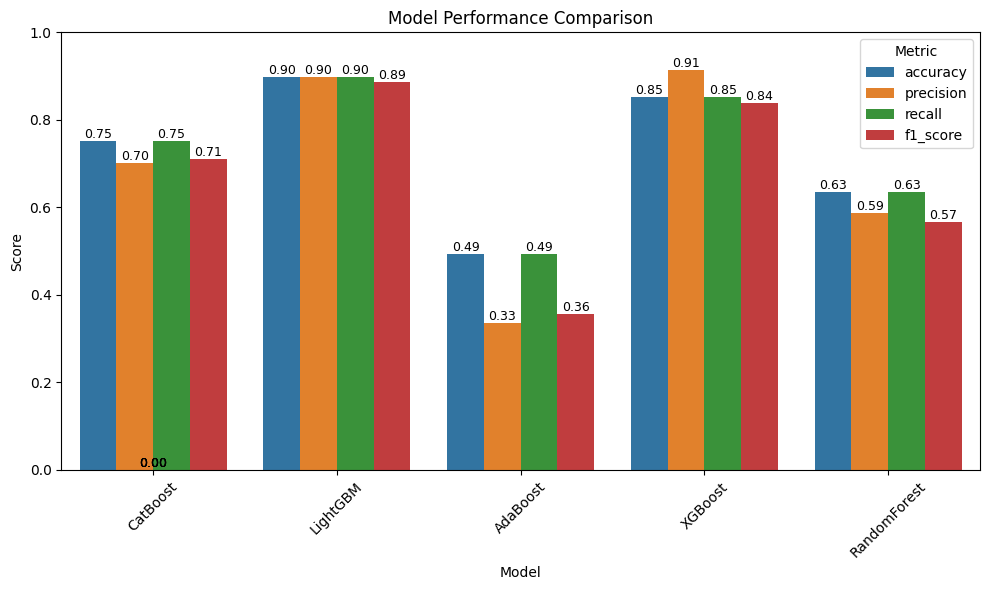

In [28]:
# Save the results to a CSV file
results_df = pd.DataFrame(results)
results_melted = results_df.melt(id_vars='model', var_name='Metric', value_name='Score')

# Plot metrics for each model
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_melted, x='model', y='Score', hue='Metric')

# Show points above bars
for p in ax.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)


plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

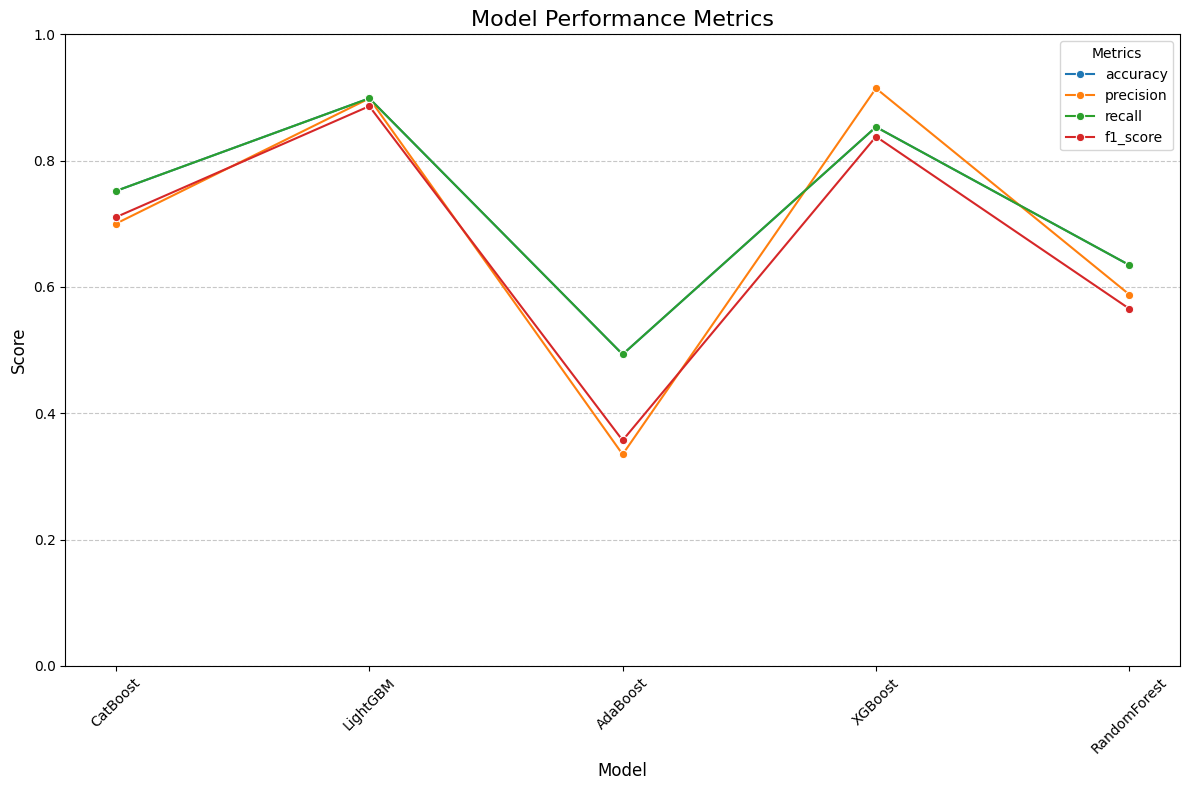

In [29]:
plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
    sns.lineplot(data=results_df, x='model', y=metric, marker='o', label=metric)

plt.title('Model Performance Metrics', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Metrics', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

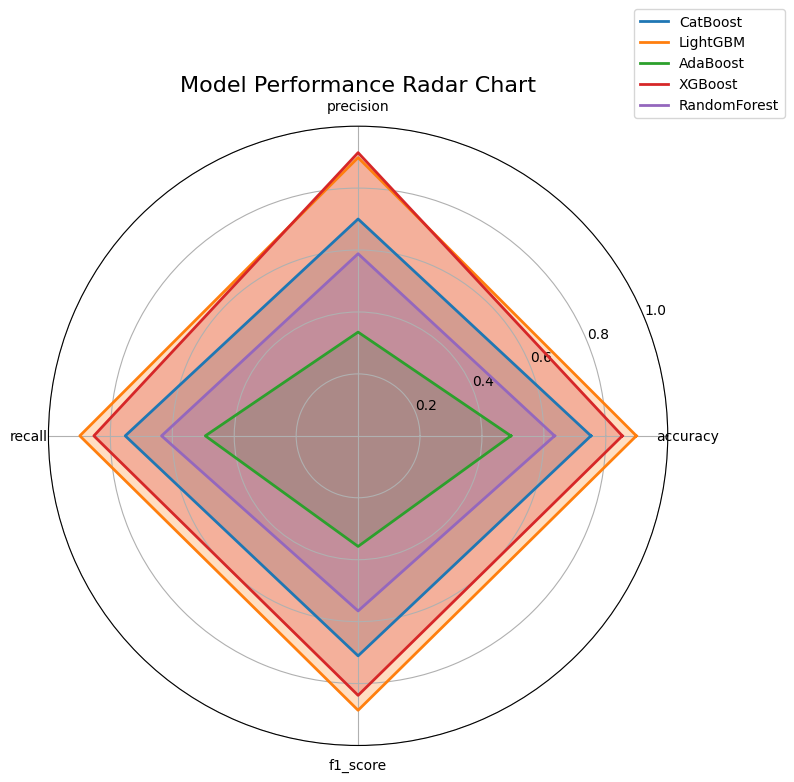

In [30]:
def radar_chart(results_df):
    categories = ['accuracy', 'precision', 'recall', 'f1_score']
    N = len(categories)

    # Normalize metrics for radar chart
    values = [results_df[categories].iloc[i].tolist() + [results_df[categories].iloc[i].tolist()[0]] for i in range(len(results_df))]
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for i, model in enumerate(results_df['model']):
        ax.plot(angles, values[i], label=model, linewidth=2)
        ax.fill(angles, values[i], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    ax.set_title("Model Performance Radar Chart", fontsize=16)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
    plt.tight_layout()
    plt.show()

radar_chart(results_df)


In [31]:
# Store the results to the Model Folder to be later used in the Front End Application

# results_df_path = f"../model/all_model_results.json"
# results_df.to_json(results_df_path, orient="records", indent=4)

Here we can see that LighstGBM performs much better than the other three modelsThe comparison of model performance revealed that boosting algorithms, such as LightBoost and XGBoost, outperform other methods in terms of both accuracy and recall. LightBoost emerged as the top-performing model, achieving consistent results across all evaluated metrics. XGBoost followed closely, demonstrating a strong recall score, which is crucial for identifying relevant cases.

The application created can be accessed Here [Drug Side Effect Prediction App](https://drug-side-effect-prediction.streamlit.app/).